# Kalman Filter & Parameter Estimation

In [1]:
import tqdm

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


### Synthetic Data

### Parameters

In [2]:
from kalman import getExperiment

experiment = 3
T = 100
A, Q, C, R = getExperiment(experiment)
A, Q, C, R


(array([[ 0.9,  0.1],
        [-0.2,  0.9]]), array([[1. , 0.1],
        [0.1, 1. ]]), array([[1, 0],
        [0, 1]]), array([[0.3, 0. ],
        [0. , 0.3]]))

### Generate Time Series

In [3]:
from kalman import generateTimeSeries

z, y = generateTimeSeries(A, C, Q, R, T+1)


### Plot

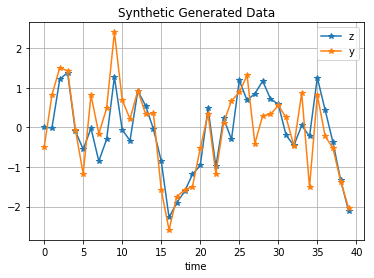

In [4]:
Tmax = 40

plt.plot(z[0,:Tmax].T, '*-')
plt.plot(y[0,:Tmax].T, '*-')
plt.legend(['z', 'y'])
plt.xlabel('time')
plt.grid()
plt.title('Synthetic Generated Data')
plt.show()


In [5]:
from kalman import getConditionalLogLikelihood
from kalman import getApproxParameters
from kalman import KalmanSmoother

### Randomly initialise parameters
numStates = A.shape[0]
Qhat = 2*Q #np.eye(numStates)
Ahat = 5*np.eye(numStates) # A
Chat = 5*np.eye(numStates) # C
Rhat = 2*R # np.cov(y).reshape(y.shape[0], y.shape[0])
zStart = z[:,0:1]
Sigma = np.eye(A.shape[0])*30
params = []

### optimal log likelihood
ztT, PtT, Pt1tT, zt1t, Pt1t, ztt, zt1t = KalmanSmoother(y[:,1:], A, C, Q, R, zStart, Sigma)
# zStart = ztT[:,0:1]
optimalLL = getConditionalLogLikelihood(y[:,1:], zt1t, Pt1t, C, R)

### training
# zStart = z[:,0:1]

for it in tqdm.tqdm(range(50)):
    ### E-step : get smoothed probabilities
    ztT, PtT, Pt1tT, zt1t, Pt1t, ztt, zt1t = KalmanSmoother(y[:,1:], Ahat, Chat, Qhat, Rhat, zStart, Sigma)
    # zStart = ztT[:,0:1]

    ### M-step : optimize parameters
    Ahat, Chat, Qhat, Rhat = getApproxParameters(ztT, PtT, Pt1tT, y[:,1:], C=C) # A=A, C=C 
    
    ### Conditional likelihood p(Y|theta)
    ll = getConditionalLogLikelihood(y[:,1:], zt1t, Pt1t, Chat, Rhat)
    
    dct = {'A':Ahat,'C':Chat,'Q':Qhat,'R':Rhat, 'zStart':zStart, 'll':ll}
    params.append(dct)


100%|██████████| 50/50 [00:00<00:00, 78.64it/s]


In [7]:
Rhat

array([[ 0.42202691, -0.06837344],
       [-0.06837344,  0.57784551]])

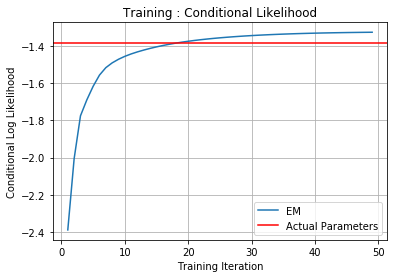

In [6]:
df = pd.DataFrame(params)[['ll']].loc[1:]

df.plot();
plt.ylabel('Conditional Log Likelihood')
plt.xlabel('Training Iteration')
# plt.xticks(df.index.astype(int))
plt.axhline(y = optimalLL, color = 'r', linestyle = '-')
plt.grid()
plt.title('Training : Conditional Likelihood')
plt.legend(['EM', 'Actual Parameters'])
plt.show()


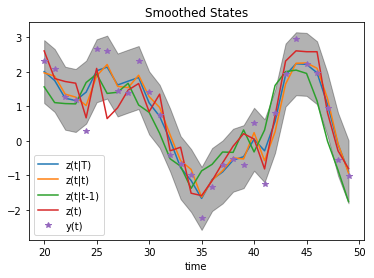

In [12]:
Tmin = 20
Tmax = 50

x = np.linspace(Tmin,Tmax-1, Tmax-Tmin)
plt.figure()
plt.fill_between(x, ztT[0,Tmin:Tmax].T-2*PtT[0,0,Tmin:Tmax].T**0.5, ztT[0,Tmin:Tmax].T+2*PtT[0,0,Tmin:Tmax]**0.5, edgecolor='black', facecolor='k', alpha=0.3)

plt.plot(x, ztT[0,Tmin:Tmax].T)
plt.plot(x, ztt[0,Tmin:Tmax].T)
plt.plot(x, zt1t[0,Tmin+1:Tmax+1].T)
plt.plot(x, z[0,Tmin:Tmax].T)
plt.plot(x, y[0,Tmin:Tmax].T, '*')
plt.xlabel('time')
plt.title('Smoothed States')
plt.legend(['z(t|T)', 'z(t|t)', 'z(t|t-1)', 'z(t)', 'y(t)'])
plt.show()


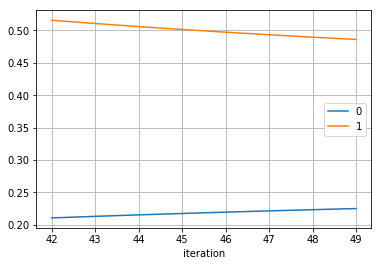

In [29]:
pd.DataFrame(params)[['R']].apply(lambda x: x[0][1], axis='columns', result_type='expand').tail(8).plot()
plt.grid()
plt.xlabel('iteration')
plt.show()


In [34]:
# Ahat, Chat, Qhat, Rhat
Qhat, Q


(array([[3.60229541, 3.52426639],
        [5.73796465, 8.59467812]]), array([[1, 0],
        [0, 1]]))

In [35]:
# pd.DataFrame(params)['zStart'].apply(lambda x:x[0]).tail(100).plot()a
states : numCases t, numCases t-1
newCases = numCases * (1+R)

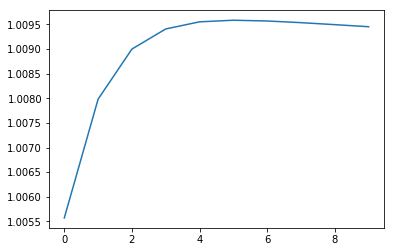

In [18]:
log((numCasest-numcases(t01))/numcasest) = 

In [12]:
# plt.hist(z.T-ztT.T, 100);
plt.plot(z.T-ztT[:,1:].T);

ValueError: operands could not be broadcast together with shapes (1001,2) (1000,2) 

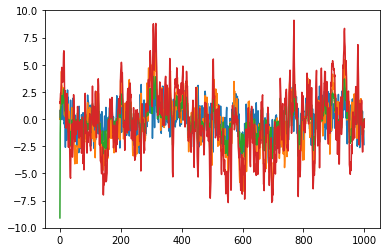

In [71]:
plt.plot(z.T)
plt.plot(ztT.T)

In [132]:
# # Initialise Matrices
# zt1t = np.zeros((numStates,T)) # z(t+1|t)
# ztt = np.zeros((numStates,T)) # z(t|t)
# ztT = np.zeros((numStates,T)) # z(t|T)
# Pt1t = np.zeros((numStates,numStates,T)) # P(t+1|t)
# Ptt = np.zeros((numStates,numStates,T)) # P(t|t)
# PtT = np.zeros((numStates,numStates,T)) # P(t|T)

# # Forward pass
# Ptt[:,:,0] = R
# ztt[:, 0] = y[:,0]

# for t in range(0, T-1):
#     zt1t[:,t] = matricesMultiply([A, ztt[:,t]])
#     Pt1t[:,:,t] = matricesMultiply([A, Ptt[:,:,t], A.T]) + Q 

#     Kt1 = matricesMultiply([Pt1t[:,:,t], C.T, np.linalg.inv(matricesMultiply([C,Pt1t[:,:,t],C.T])+R)])
#     ztt[:,t+1] = zt1t[:,t] + matricesMultiply([Kt1, y[:,t+1]-matricesMultiply([C, zt1t[:,t]])])
#     Ptt[:,:,t+1] = Pt1t[:,:,t] - matricesMultiply([Kt1, C, Pt1t[:,:,t]])
        
# # Backward pass
# PtT[:,:,T-1] = Ptt[:,:,T-1]
# ztT[:,T-1] = ztt[:,T-1]
# for t in range(T-2,-1,-1):
#     Lt = matricesMultiply([Ptt[:,:,t], A.T, np.linalg.inv(Pt1t[:,:,t])])
#     ztT[:,t] = ztt[:,t] + np.matmul(Lt, ztT[:,t+1]-zt1t[:,t])
#     PtT[:,:,t] = Ptt[:,:,t] + matricesMultiply([Lt, PtT[:,:,t+1] - Pt1t[:,:,t], Lt.T])     


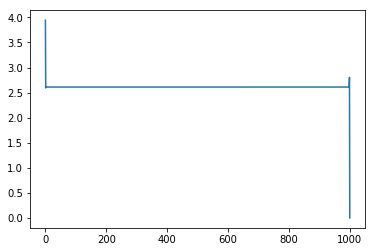

In [42]:
# plt.plot(Ptt[0,0,:])
plt.plot(PtT[0,0,:])
plt.show()


In [43]:
plt.plot(z[0,:].T)
plt.plot(ztt[0,:].T)
plt.plot(ztT[0,:].T)
plt.plot(y[0,:].T)
plt.legend(['z', 'z(t|t)', 'z(t|T)', 'y'])
plt.grid()
# plt.ylim([y.min(), y.max()])
plt.show()


NameError: name 'ztt' is not defined

# Maximization

In [ ]:
def getParameters(z, PtT, Pt1tT, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = np.matmul(sum([
            matricesMultiply([z[:,t+1:t+2], z[:,t:t+1].T] + Pt1tT[:,:,t]) for t in range(T-1)]), 
        np.linalg.inv(sum([np.matmul(z[:,t:t+1], z[:,t:t+1].T) for t in range(T-1)])+np.eye(z.shape[0])*0.01))
    if C is None:
        C = np.matmul(sum([np.matmul(y[:,t:t+1], z[:,t:t+1].T) for t in range(T)]), np.linalg.inv(sum([np.matmul(z[:,t:t+1], z[:,t:t+1].T) for t in range(T)])+np.eye(z.shape[0])*0.01))
    if Q is None:
        Q = 1/(T-1)*sum([matricesMultiply([z[:,t+1:t+2], z[:,t+1:t+2].T])
        - matricesMultiply([z[:,t+1:t+2], z[:,t:t+1].T, A.T])
        - matricesMultiply([A, z[:,t:t+1], z[:,t+1:t+2].T])
        + matricesMultiply([A, z[:,t:t+1], z[:,t:t+1].T, A.T])  for t in range(T-1)])
    if R is None:
        R = 1/T * sum(
        [matricesMultiply([y[:,t:t+1], y[:,t:t+1].T])
        - matricesMultiply([y[:,t:t+1], z[:,t:t+1].T, C.T])
        - matricesMultiply([C, z[:,t:t+1], y[:,t:t+1].T])
        + matricesMultiply([C, z[:,t:t+1], z[:,t:t+1].T, C.T])  for t in range(T)]
        )
    return A, C, Q, R

A, C, Q, R = getParameters(z, y)
A, C, Q, R

In [ ]:
def getSmoothedFit(y, A, C, Q, R, zStart, numStates):
    T = y.shape[1]
    
    # Initialise Matrices
    zt1t = np.zeros((numStates,T)) # z(t+1|t)
    ztt = np.zeros((numStates,T)) # z(t|t)
    ztT = np.zeros((numStates,T)) # z(t|T)
    Pt1t = np.zeros((numStates,numStates,T)) # P(t+1|t)
    Ptt = np.zeros((numStates,numStates,T)) # P(t|t)
    PtT = np.zeros((numStates,numStates,T)) # P(t|T)
    Pt1tT = np.zeros((numStates, numStates, T))

    # Forward pass
    Ptt[:,:,0] = R
    ztt[:, 0] = zStart

    for t in range(0, T-1):
        zt1t[:,t] = matricesMultiply([A, ztt[:,t]])
        Pt1t[:,:,t] = matricesMultiply([A, Ptt[:,:,t], A.T]) + Q 
        Kt1 = matricesMultiply([Pt1t[:,:,t], C.T, np.linalg.inv(matricesMultiply([C,Pt1t[:,:,t],C.T])+R+np.eye(R.shape[0])*0.1)])
        ztt[:,t+1] = zt1t[:,t] + matricesMultiply([Kt1, y[:,t+1]-matricesMultiply([C, zt1t[:,t]])])
        Ptt[:,:,t+1] = Pt1t[:,:,t] - matricesMultiply([Kt1, C, Pt1t[:,:,t]])
            
    # Backward pass
    PtT[:,:,T-1] = Ptt[:,:,T-1]
    ztT[:,T-1] = ztt[:,T-1]

    for t in range(T-2,-1,-1):
        Lt = matricesMultiply([Ptt[:,:,t], A.T, np.linalg.inv(Pt1t[:,:,t]+np.eye(Pt1t.shape[0])*0.1)])
        ztT[:,t] = ztt[:,t] + np.matmul(Lt, ztT[:,t+1]-zt1t[:,t])
        PtT[:,:,t] = Ptt[:,:,t] + matricesMultiply([Lt, PtT[:,:,t+1] - Pt1t[:,:,t], Lt.T])  
        Pt1tT = matricesMultiply([PtT[:,:,t+1], np.linalg.inv(Pt1t[:,:,t]), A, Ptt[:,:,t]])

    return ztT, PtT, Pt1tT

# ztT = getSmoothedFit(y, A, C, Q, R, numStates=numStates)


In [ ]:
def getParameters(z, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = sum([z[:,t+1:t+2] @ z[:,t:t+1].T for t in range(T-1)]) @ np.linalg.inv( sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T-1)]) + np.eye(z.shape[0])*0.01 )

    if C is None:
        C = sum([y[:,t:t+1] @ z[:,t:t+1].T for t in range(T)]) @ np.linalg.inv(sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T)])+np.eye(z.shape[0])*0.01)
    if Q is None:
        Q = 1/(T-1)*sum([z[:,t+1:t+2] @ z[:,t+1:t+2].T 
        - z[:,t+1:t+2] @ z[:,t:t+1].T @ A.T 
        - A @ z[:,t:t+1] @ z[:,t+1:t+2].T 
        + A @ z[:,t:t+1] @ z[:,t:t+1].T @ A.T  for t in range(T-1)])
    if R is None:
        R = 1/T * sum([
            y[:,t:t+1] @ y[:,t:t+1].T
            - y[:,t:t+1] @ z[:,t:t+1].T @ C.T
            - C @ z[:,t:t+1] @ y[:,t:t+1].T
            + C @ z[:,t:t+1] @ z[:,t:t+1].T @ C.T  for t in range(T)])
    return A, C, Q, R

def getApproxParameters(z, PtT, Pt1tT, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = sum([z[:,t+1:t+2] @ z[:,t:t+1].T + Pt1tT[:,:,t] for t in range(T-1)]) @ np.linalg.inv( sum([z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t] for t in range(T-1)]) + np.eye(z.shape[0])*0.0001 )
    if C is None:
        C = sum([y[:,t:t+1] @ z[:,t:t+1].T for t in range(T)]) @ np.linalg.inv(sum([z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t].T for t in range(T)])+np.eye(z.shape[0])*0.0001)
    if Q is None:
        Q = 1/(T-1)*sum([z[:,t+1:t+2] @ z[:,t+1:t+2].T + PtT[:,:,t+1]
        - (z[:,t+1:t+2] @ z[:,t:t+1].T + Pt1tT[:,:,t]) @ A.T 
        - A @ ( z[:,t:t+1] @ z[:,t+1:t+2].T + Pt1tT[:,:,t].T)
        + A @ (z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t]) @ A.T  for t in range(T-1)])
    if R is None:
        R = 1/T * sum([
            y[:,t:t+1] @ y[:,t:t+1].T
            - y[:,t:t+1] @ z[:,t:t+1].T @ C.T
            - C @ z[:,t:t+1] @ y[:,t:t+1].T
            + C @ (z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t]) @ C.T  for t in range(T)])

    return A, C, Q, R

# A, C, Q, R = getParameters(z, y)
# A, C, Q, R
ztT, PtT, Pt1tT = getSmoothedFit(y, A, C, Q, R, zStart=z[:,0], numStates=numStates)

AHat, CHat, QHat, RHat = getApproxParameters(ztT, PtT, Pt1tT, y)
AHat, CHat, QHat, RHat

def getParameters(z, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = sum([z[:,t+1:t+2] @ z[:,t:t+1].T for t in range(T-1)]) @ np.linalg.inv( sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T-1)]) + np.eye(z.shape[0])*0.01 )

    if C is None:
        C = sum([y[:,t:t+1] @ z[:,t:t+1].T for t in range(T)]) @ np.linalg.inv(sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T)])+np.eye(z.shape[0])*0.01)
    if Q is None:
        Q = 1/(T-1)*sum([z[:,t+1:t+2] @ z[:,t+1:t+2].T 
        - z[:,t+1:t+2] @ z[:,t:t+1].T @ A.T 
        - A @ z[:,t:t+1] @ z[:,t+1:t+2].T 
        + A @ z[:,t:t+1] @ z[:,t:t+1].T @ A.T  for t in range(T-1)])
    if R is None:
        R = 1/T * sum([
            y[:,t:t+1] @ y[:,t:t+1].T
            - y[:,t:t+1] @ z[:,t:t+1].T @ C.T
            - C @ z[:,t:t+1] @ y[:,t:t+1].T
            + C @ z[:,t:t+1] @ z[:,t:t+1].T @ C.T  for t in range(T)])
    return A, C, Q, R

def getApproxParameters(z, PtT, Pt1tT, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = sum([z[:,t+1:t+2] @ z[:,t:t+1].T + Pt1tT[:,:,t] for t in range(T-1)]) @ np.linalg.inv( sum([z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t] for t in range(T-1)]) + np.eye(z.shape[0])*0.0001 )
    if C is None:
        C = sum([y[:,t:t+1] @ z[:,t:t+1].T for t in range(T)]) @ np.linalg.inv(sum([z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t].T for t in range(T)])+np.eye(z.shape[0])*0.0001)
    if Q is None:
        Q = 1/(T-1)*sum([z[:,t+1:t+2] @ z[:,t+1:t+2].T + PtT[:,:,t+1]
        - (z[:,t+1:t+2] @ z[:,t:t+1].T + Pt1tT[:,:,t]) @ A.T 
        - A @ ( z[:,t:t+1] @ z[:,t+1:t+2].T + Pt1tT[:,:,t].T)
        + A @ (z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t]) @ A.T  for t in range(T-1)])
    if R is None:
        R = 1/T * sum([
            y[:,t:t+1] @ y[:,t:t+1].T
            - y[:,t:t+1] @ z[:,t:t+1].T @ C.T
            - C @ z[:,t:t+1] @ y[:,t:t+1].T
            + C @ (z[:,t:t+1] @ z[:,t:t+1].T + PtT[:,:,t]) @ C.T  for t in range(T)])

    return A, C, Q, R

# A, C, Q, R = getParameters(z, y)
# A, C, Q, R
ztT, PtT, Pt1tT = getSmoothedFit(y, A, C, Q, R, zStart=z[:,0], numStates=numStates)

AHat, CHat, QHat, RHat = getApproxParameters(ztT, PtT, Pt1tT, y)
AHat, CHat, QHat, RHat

In [ ]:
def getParameters(z, y, A=None, C=None, Q=None, R=None):
    T = y.shape[1]
    if A is None:
        A = sum([z[:,t+1:t+2] @ z[:,t:t+1].T for t in range(T-1)]) @ np.linalg.inv( sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T-1)]) + np.eye(z.shape[0])*0.01 )

    if C is None:
        C = sum([y[:,t:t+1] @ z[:,t:t+1].T for t in range(T)]) @ np.linalg.inv(sum([z[:,t:t+1] @ z[:,t:t+1].T for t in range(T)])+np.eye(z.shape[0])*0.01)
    if Q is None:
        Q = 1/(T-1)*sum([z[:,t+1:t+2] @ z[:,t+1:t+2].T 
        - z[:,t+1:t+2] @ z[:,t:t+1].T @ A.T 
        - A @ z[:,t:t+1] @ z[:,t+1:t+2].T 
        + A @ z[:,t:t+1] @ z[:,t:t+1].T @ A.T  for t in range(T-1)])
    if R is None:
        R = 1/T * sum([
            y[:,t:t+1] @ y[:,t:t+1].T
            - y[:,t:t+1] @ z[:,t:t+1].T @ C.T
            - C @ z[:,t:t+1] @ y[:,t:t+1].T
            + C @ z[:,t:t+1] @ z[:,t:t+1].T @ C.T  for t in range(T)])
    return A, C, Q, R

def getLogLikelihood(ztT, y, A, C, Q, R):
    T = y.shape[1]
    ll = 1/T*(-0.5 * (T-1) * np.log(np.linalg.det(Q)) 
        -0.5*sum([(ztT[:,t+1] - A @ ztT[:,t]).T @ np.linalg.inv(Q) @ (ztT[:,t+1] - A @ ztT[:,t]) for t in range(T-1)]) 
        -0.5 * T * np.log(np.linalg.det(R)) 
        -0.5*sum([(y[:,t] - C @ ztT[:,t]).T @ np.linalg.inv(R) @ (y[:,t] - C @ ztT[:,t]) for t in range(T)]))
    return ll

def matricesMultiply(matrices):
    res = np.eye(matrices[0].shape[0])
    for matrix in matrices:
        res = np.matmul(res, matrix)
    return res
